In [1]:

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
from keras.regularizers import l2



tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [2]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
# Dataset folders 
dataset_dir = 'dataset96'
training_dir = "dataset96/train"
validation_dir = "dataset96/val"

In [5]:
# All the categories to classify the dataset
labels = ['Species1',              # 0
          'Species2',          # 1
          "Species3",             # 2
          "Species4",          # 3
          "Species5",            # 4
          "Species6",             # 5
          "Species7",         # 6
          "Species8"]             # 7

In [6]:
aug_train_data_gen = ImageDataGenerator(rotation_range=50,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        zoom_range=0.5,
                                        shear_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       interpolation="bicubic",
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=128,
                                                       shuffle=True,
                                                       seed=seed)

valid_data_gen = ImageDataGenerator(rescale=1/255.)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               interpolation="bicubic",
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [7]:
def get_next_batch(generator):
  batch = next(generator)
    
  print("batch \n")
  #print(batch)

  image = batch[0]*255
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

batch 

(Input) image shape: (128, 96, 96, 3)
Target shape: (128, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


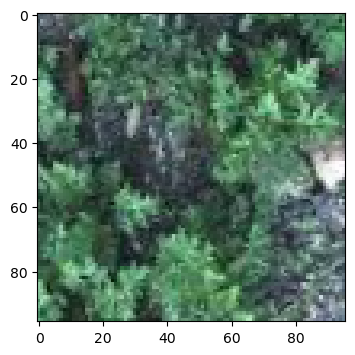

In [8]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [11]:
# This calculate the weights for all the classes
# by counting the number of images for each class
# and dividing by the number of total images
category_weight = {}
elements_per_class = {}
i=0
classes = 8
path = "datasetNoTest2/train"
dirs = os.listdir(path)
for d in dirs:
    category_weight[i] = 0.0
    elements_per_class[i] = len(os.listdir(path+"/"+d))
    i=i+1

total_images = sum(elements_per_class.values())

for i in category_weight.keys():
    category_weight[i] = total_images / (classes * elements_per_class[i])
    
print(category_weight)

{0: 2.3866906474820144, 1: 0.831453634085213, 2: 0.8594559585492227, 3: 0.8661879895561357, 4: 0.8335427135678392, 5: 1.9984939759036144, 6: 0.8252487562189055, 7: 0.8707349081364829}


In [12]:

class_weights = {0: 2.389358108108108, 
                 1: 0.8320588235294117, 
                 2: 0.8583131067961165, 
                 3: 0.8667279411764706, 
                 4: 0.8340212264150944, 
                 5: 1.9978813559322033, 
                 6: 0.8243006993006993, 
                 7: 0.8709975369458128}

In [13]:
# VGG16 architrecture taken from: https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
m_batch_size = 64
m_epochs = 100
m_img_h = 96 # Height of the image.
m_img_w = 96 # Width of the image.
m_num_classes = 3 # Number of classes.
m_resize_size = (96,96)
m_rescale = 1/255 # Rescale to bring the color from the [0, 255] range to the [0, 1] range.
m_regularizer_value = 0.0001 # The L2 regularizer value to be used on the model to avoid overfitting.
m_freeze_layer = 0 # Layer to freeze in th VGG16 model.

# Settings
enable_validation_set = True # Set to False to avoid splitting the training data in training and validation.
enable_early_stop = True
enable_finetuning_on_vgg_model = True
enable_model_checkpoint = False # Disabled due too much storage utilization on Google Drive.
reduce_lr_on_plateau = True
adaptive_learning_rate = False

img_input = tf.keras.layers.Input(shape=[96, 96, 3])
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(m_regularizer_value))(img_input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(m_regularizer_value))(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
vgg = tf.keras.Model(img_input, x, name='vgg16')
vgg.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') # Weights downloaded from: https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
if enable_finetuning_on_vgg_model:
  freeze_until = m_freeze_layer # Layer from which we want to fine-tune.
  for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
else:
  vgg.trainable = False
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3, seed = seed))
model.add(tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(m_regularizer_value)))
model.add(tf.keras.layers.Dense(units=8, activation='softmax', kernel_regularizer=l2(m_regularizer_value)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 17,078,600
Trainable params: 17,078,600
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint(filepath='/notebooks/model_checkpoints/vgg19t.h5',verbose=1,monitor='val_accuracy', save_best_only=True, mode='max')]

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [16]:
if enable_validation_set:
  history = model.fit(x=aug_train_gen,
                      epochs=m_epochs,
                      steps_per_epoch=len(aug_train_gen), # len(train_gen) already considers the batch size!
                      validation_data=valid_gen,
                      class_weight=class_weights,
                      validation_steps=len(valid_gen), # len(valid_gen) already considers the batch size!
                      callbacks=callbacks)
else:
  history = model.fit(x=train_dataset,
                      epochs=m_epochs,
                      steps_per_epoch=len(train_gen), # len(train_gen) already considers the batch size!
                      callbacks=callbacks)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 2.1811 - accuracy: 0.2411
Epoch 1: val_accuracy improved from -inf to 0.36045, saving model to /notebooks/model_checkpoints\vgg19t.h5
23/23 [==============================] - 152s 7s/step - loss: 2.1811 - accuracy: 0.2411 - val_loss: 1.7749 - val_accuracy: 0.3604
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.7857 - accuracy: 0.4072
Epoch 2: val_accuracy improved from 0.36045 to 0.49369, saving model to /notebooks/model_checkpoints\vgg19t.h5
23/23 [==============================] - 161s 7s/step - loss: 1.7857 - accuracy: 0.4072 - val_loss: 1.5394 - val_accuracy: 0.4937
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.6565 - accuracy: 0.4422
Epoch 3: val_accuracy improved from 0.49369 to 0.53857, saving model to /notebooks/model_checkpoints\vgg19t.h5
23/23 [==============================] - 162s 7s/step - loss: 1.6565 - accuracy: 0.4422 - val_loss: 1.4744 - val_accuracy: 0.

Epoch 28/100
23/23 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.8395
Epoch 28: val_accuracy did not improve from 0.84572
23/23 [==============================] - 164s 7s/step - loss: 0.6650 - accuracy: 0.8395 - val_loss: 0.6954 - val_accuracy: 0.8373
Epoch 29/100
23/23 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.8572
Epoch 29: val_accuracy did not improve from 0.84572
23/23 [==============================] - 162s 7s/step - loss: 0.6212 - accuracy: 0.8572 - val_loss: 0.7513 - val_accuracy: 0.8247
Epoch 30/100
 1/23 [>.............................] - ETA: 20s - loss: 0.3514 - accuracy: 0.9231

KeyboardInterrupt: 

In [29]:
model.save("Good_VGG_2.1")

INFO:tensorflow:Assets written to: Good_VGG_2.1/assets


INFO:tensorflow:Assets written to: Good_VGG_2.1/assets
